In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Random number generator
rng = np.random.default_rng()

In [5]:
def check_time_difference(da, ref_time, max_diff):
    time_diff = np.abs(da.time.values - ref_time.values)
    max_time_diff = np.max(time_diff)
    
    # If the maximum time difference is greater than the allowed threshold, raise an error
    if max_time_diff > max_diff:
        raise ValueError(f"Time difference exceeds max diff: ({max_diff}) by: {max_time_diff.item()*1e-9:.2f} seconds")


def convert_ensemble_ndarray_to_ds(data, da_like, time_axis=False, da_name='u_m'):
    data_vars = {}
    
    # Loop over ensemble members
    for i in range(data.shape[0]):
        # Get individual ensemble data as np.ndarray (of shape model_shape) 
        member_data = data[i]  

        # Create a new DataArray with the updated data, using original dims and coords and add to dict
        new_da = xr.DataArray(
            data=member_data,
            dims=da_like.dims,
            coords=da_like.coords,
            attrs=da_like.attrs  
        )
        data_vars[f"{da_name}{str(i).zfill(2)}"] = new_da

        if time_axis:
            new_da['time'] = new_da['time'].dt.round('s')
            if i == 0: ref_time = new_da['time']
            # Check that the same time-index has at most 30s difference (difference due to numeric scheme CFL-criterion)
            check_time_difference(da=new_da, ref_time=ref_time, max_diff=np.timedelta64(30, 's'))

    # Create a new Dataset from the data_vars dictionary, preserving original attributes
    ds_model_post = xr.Dataset(data_vars=data_vars)
    return ds_model_post

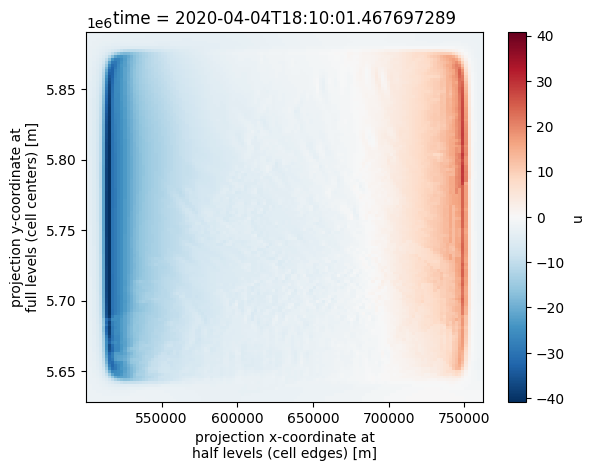

In [28]:
da_u.isel(time=0).sel(zf=slice(0,200)).mean(dim='zf').plot()

Load member 01
Load member 02
Load member 03
Load member 04
Load member 05


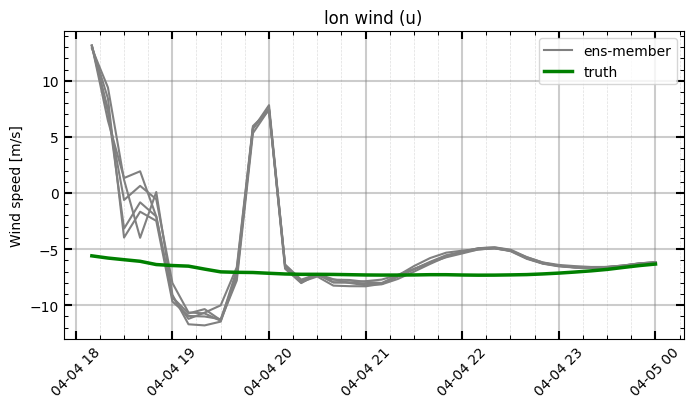

In [30]:
## Generate ensemble members and predicted measurements for all ens. members

model_prior, data_prior = [], []

for i in range(NE):
    # Get ensemble member index as a str of length two and filled with 0s (e.g. 1 -> "01", 10 -> "10")
    print(f"Load member {str(i+1).zfill(2)}")
    da_data, _    = load_SimData_member(path=f"{data_directory}_m{str(i+1).zfill(2)}", z_bounds=Z_BOUNDS)
    ds_restart = load_ic_member(path=f"{sims_directory}_m{str(i+1).zfill(2)}", z_bounds=Z_BOUNDS)

    # Extract predicted measurements
    da_u_predobs = measurement_operator(da_data)
    data_prior.append(da_u_predobs)
    model_prior.append(ds_restart["u"])



# Convert list to numpy array
data_prior  = np.asarray(data_prior)
model_prior = np.asarray(model_prior)

# Convert to xr.DataSet
ds_data_prior  = convert_ensemble_ndarray_to_ds(data=data_prior, da_like=da_u_predobs, time_axis=True)
ds_model_prior = convert_ensemble_ndarray_to_ds(data=model_prior, da_like=ds_restart["u"], time_axis=False)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharey=True)

u_members = [ds_data_prior['u_m00'], ds_data_prior['u_m01'], ds_data_prior['u_m02'], ds_data_prior['u_m03'], ds_data_prior['u_m04']]

ax = [ax]

for i in range(len(u_members)):
    u_data = u_members[i].sel(zf=slice(0,200)).mean(dim='zf')

    x_dat = u_data.time.values
    
    if i ==0:
        ax[0].plot(x_dat, u_data, color='grey', label='ens-member')
    else:
        ax[0].plot(x_dat, u_data, color='grey',)
    # ax[1].plot(x_dat, v_data, label=f'Mem: {i+1}', color='grey')
    # ax[2].plot(x_dat, M_data, label=f'Mem: {i+1}', color='grey')

    ax[0].set_title("lon wind (u)")
    # ax[1].set_title("lat wind (v)")
    # ax[2].set_title("wind mag (M)")

    ax[0].set_ylabel("Wind speed [m/s]")

    for idx in range(1):
        # Grid settings: Major grid lines wider, minor grid lines thinner
        ax[idx].grid(True, axis='both', which='major', linestyle='-' , color='grey', alpha=0.4, linewidth=1.5, zorder=1)  # Major gridlines
        ax[idx].grid(True, axis='x'   , which='minor', linestyle='--', color='grey', alpha=0.25, linewidth=0.5, zorder=1)  # Minor gridlines

        # Rotate x-tick labels for better readability
        ax[idx].tick_params(axis='both', which='major', direction='in', length=6, width=1.5, top=True, right=True)
        ax[idx].tick_params(axis='both', which='minor', direction='in', length=3, width=0.75, top=True, right=True)
        ax[idx].tick_params(axis='x', rotation=45)
        ax[idx].minorticks_on()



# u_noisyobs = ds_noisyobs.sel(level=slice(0,200)).mean(dim='level')
u_ref = da_u_obs.sel(zf=slice(0,200)).mean(dim='zf')

ax[0].plot(x_dat, u_ref, color = 'green', linewidth=2.5, label='truth')
# ax[0].plot(x_dat, u_noisyobs, marker='*', linestyle='', color = 'red', markersize=5, label='noisy_obs')
ax[0].legend()

# ax[0].set_ylim(-11,-5)
# ax[2].legend()
